# 用omicverse对scRNA-seq数据进行预处理
计数表是基因细胞的数字矩阵，是单细胞rna测序数据分析的基本输入数据结构。一个常见的预处理步骤是调整可变采样效率的计数，并对它们进行变换，使方差在整个动态范围内相似。

合适的预处理方法对ScRNA序列非常重要。在这里，我们介绍了一些预处理步骤，以帮助研究人员更容易地进行下游分析。

用户可以比较我们的教程和scanpy的教程来学习如何使用omicverse

Colab_Reproducibility：https://colab.research.google.com/drive/1DXLSls_ppgJmAaZTUvqazNC_E7EDCxUe?usp=sharing

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set()


/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.29' not found (required by /slurm/home/admin/.conda/envs/grns/lib/python3.11/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "



   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.5, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


该数据由来自健康捐赠者的3k个pbmc组成，可从10x Genomics免费获得([此处](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)来自此[网页](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k))。在unix系统上，您可以取消注释并运行以下命令来下载并解压缩数据。最后一行创建一个目录，用于写入处理过的数据。

In [ ]:
# !mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz


In [4]:
!cd ../../../data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [6]:
adata = sc.read_10x_mtx(
    '../../../data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
adata

... writing an h5ad cache file to speedup reading next time


AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [8]:
adata.var_names_make_unique()
adata.obs_names_make_unique()


In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## 预处理
### 质量控制

对于单细胞数据，我们需要在分析前进行质量控制，包括去除含有双细胞、低表达细胞和低表达基因的细胞。除此之外，我们还需要根据线粒体基因比例、转录本数量、每个细胞表达的基因数量、细胞复杂性等进行筛选。有关不同qc的详细说明，请参阅文档
https://hbctraining.github.io/scRNA-seq/lessons/04_SC_quality_control.html


COMPOSITE(复合泊松多组检测模型)是一种用于单细胞单组学和多组学设置中多组检测的计算工具。它已被实现为自动化管道，并且可以作为具有用户友好界面和Python包的基于云的应用程序使用。

Hu, H., Wang, X., Feng, S. et al. A unified model-based framework for doublet or multiplet detection in single-cell multiomics data. Nat Commun 15, 5562 (2024). https://doi.org/10.1038/s41467-024-49448-x

In [10]:
adata=ov.pp.qc(adata,
              tresh={'mito_perc': 0.2, 'nUMIs': 500, 'detected_genes': 250},
               doublets_method='sccomposite',
              batch_key=None)
adata

CPU mode activated
Calculate QC metrics
End calculation of QC metrics.
Original cell number: 2700
!!!It should be noted that the `sccomposite` will remove more cells than `scrublet`!!!
Begin of post doublets removal and QC plot using `sccomposite`
Cuda is available; Fitting the COMPOSITE model on the RNA modality
Found 1 GPUs available. Using GPU 0 (NVIDIA RTX A6000) of compute capability 8.6 with 51.0Gb total memory.

The RNA modality goodness-of-fit score is: 4.268524182045417 
<3: poor fit 
3~5: moderate fit 
>5: good fit
Cells retained after sccomposite: 2516, 184 removed.
End of post sccomposite removal and QC plots.
Filters application (seurat or mads)
Lower treshold, nUMIs: 500; filtered-out-cells: 0
Lower treshold, n genes: 250; filtered-out-cells: 3
Lower treshold, mito %: 0.2; filtered-out-cells: 2
Filters applicated.
Total cell filtered out with this last --mode seurat QC (and its chosen options): 5
Cells retained after scrublet and seurat filtering: 2511, 189 removed.
filte

AnnData object with n_obs × n_vars = 2511 × 13355
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells'

## 高变量基因检测

这里我们尝试使用皮尔逊的方法来计算高度可变的基因。这是建议优于普通归一化的方法。详见Nature Method中的[文章](https://www.nature.com/articles/s41592-023-01814-1#MOESM3)。

normalize| hvg:我们使用`|`来控制预处理步骤，`|`之前用于归一化步骤，可以是`shiftlog`或`pearson`，`|`之后用于高度可变的基因计算步骤，可以是`pearson`或`seurat`。我们的默认值是`shiftlog|pearson`。

In [11]:
adata=ov.pp.preprocess(adata,mode='shiftlog|pearson',n_HVGs=2000,)
adata

Begin robust gene identification
After filtration, 13355/13355 genes are kept. Among 13355 genes, 13355 genes are robust.
End of robust gene identification.
Begin size normalization: shiftlog and HVGs selection pearson
normalizing counts per cell. The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:00)
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'highly_variable_nbatches', int vector (adata.var)
    'highly_variable_intersection', boolean vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'residual_variances', float vector (adata.var)
Time to analyze data in cpu: 1.8549308776855469 seconds.
End of size normalization: shiftlog and HVGs selection pearson


AnnData object with n_obs × n_vars = 2511 × 13355
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts'

将AnnData对象的.raw属性设置为标准化和对数化的原始基因表达，以便稍后在差异测试和基因表达可视化中使用。这只是冻结了AnnData对象的状态。

In [12]:
adata.var.highly_variable_features

AL627309.1       False
AP006222.2       False
RP11-206L10.2    False
LINC00115        False
NOC2L            False
                 ...  
AC145212.1       False
AL592183.1       False
AL354822.1       False
PNRC2-1          False
SRSF10-1         False
Name: highly_variable_features, Length: 13355, dtype: bool

In [13]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable_features]
adata


View of AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## 主成分分析
与scanpy相反，我们不直接缩放原始表达式矩阵的方差，而是将方差缩放的结果存储在层中，因为缩放可能会导致数据分布的变化，并且我们没有发现缩放在除主成分分析之外的任何场景中都是有意义的

In [14]:
%%time
ov.pp.scale(adata)
adata

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
CPU times: user 422 ms, sys: 11.1 ms, total: 433 ms
Wall time: 416 ms


AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg'
    layers: 'counts', 'scaled'

如果你想在normlog层中执行pca，你可以设置`layer=normlog`，但是我们认为在pca中缩放是必要的。

In [15]:
%%time
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

computing PCA
    with n_comps=50
    finished (0:00:00)
CPU times: user 3.8 s, sys: 1.56 s, total: 5.36 s
Wall time: 689 ms


AnnData object with n_obs × n_vars = 2511 × 2000
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'counts', 'scaled', 'lognorm'

In [17]:
adata.obsm['scaled|original|X_pca'].shape

(2511, 50)

In [20]:
adata.varm["scaled|original|pca_loadings"].shape

(2000, 50)

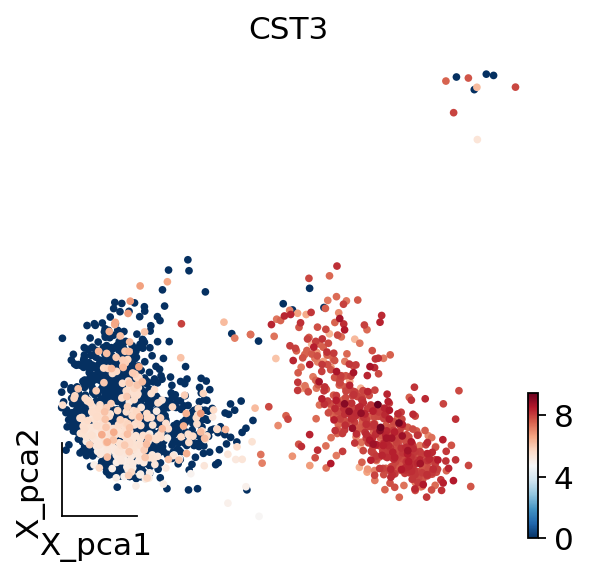

In [21]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']
ov.pl.embedding(adata,
                basis='X_pca',
                color='CST3',
                frameon='small')

## 嵌入邻域图

我们建议使用UMAP将图嵌入到二维中(McInnes等人，2018)，见下文。它可能比tSNE更忠实于流形的全球连通性，也就是说，它更好地保留了轨迹。在某些情况下，您可能仍然会观察到断开连接的集群和类似的连接违规。它们通常可以通过跑步来弥补

In [22]:
ov.pp.neighbors(adata, 
                n_neighbors=15, n_pcs=50,
                use_rep='scaled|original|X_pca')

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
CPU times: user 7.97 s, sys: 195 ms, total: 8.17 s
Wall time: 8.15 s


您还可以使用umap将邻域图可视化

In [23]:
%%time
ov.pp.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
CPU times: user 4.36 s, sys: 263 ms, total: 4.62 s
Wall time: 4.05 s


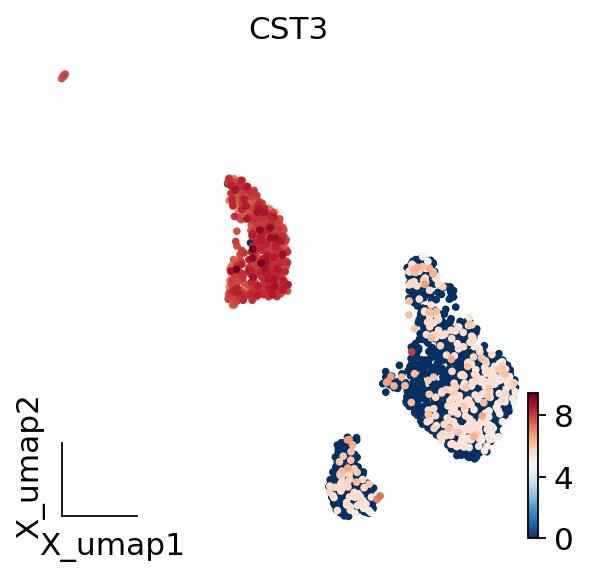

In [24]:
ov.pl.embedding(adata,
                basis='X_umap',
                color='CST3',
                frameon='small')

为了可视化PCA的嵌入，我们使用了omicverse中的pymde包包装器。这是gpu加速的UMAP的替代方案。

In [26]:
ov.pp.mde(adata,
          embedding_dim=2,
          n_neighbors=15, 
          basis='X_mde',
          n_pcs=50, 
          use_rep='scaled|original|X_pca',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsm['X_mde']`, MDE coordinates
    `.obsp['neighbors_distances']`, distances for each pair of neighbors
    `.obsp['neighbors_connectivities']`, weighted adjacency matrix (0:00:03)


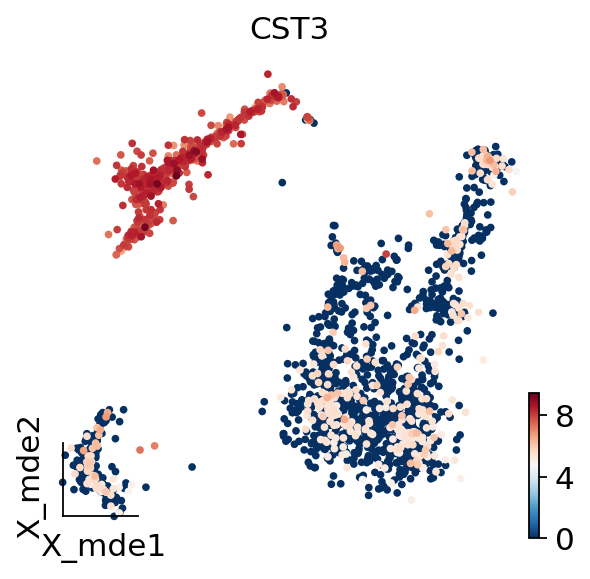

In [27]:
ov.pl.embedding(adata,
                basis='X_mde',
                color='CST3',
                frameon='small')

## 评分细胞周期
在Omicverse中，我们将G1M/S和G2M基因都存储在该功能（人和小鼠）中，因此您可以运行细胞周期分析而无需手动输入周期基因！

In [ ]:
adata_raw=adata.raw.to_adata()


In [34]:
adata_raw

AnnData object with n_obs × n_vars = 2511 × 13355
    obs: 'nUMIs', 'mito_perc', 'detected_genes', 'cell_complexity', 'sccomposite_doublet', 'sccomposite_consistency', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'mt', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'log1p', 'hvg', 'pca', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'neighbors', 'umap'
    obsm: 'X_pca', 'scaled|original|X_pca', 'X_umap', 'X_mde'
    obsp: 'distances', 'connectivities'

In [29]:

ov.pp.score_genes_cell_cycle(adata_raw,species='human')

calculating cell cycle phase
computing score 'S_score'
       'E2F8'],
      dtype='object')
    finished: added
    'S_score', score of gene set (adata.obs).
    728 total control genes are used. (0:00:00)
computing score 'G2M_score'
       'TTK', 'CDC25C', 'KIF2C', 'DLGAP5', 'CDCA2', 'CDCA8', 'HMMR', 'ANLN',
       'NEK2', 'GAS2L3', 'CENPA'],
      dtype='object')
    finished: added
    'G2M_score', score of gene set (adata.obs).
    769 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


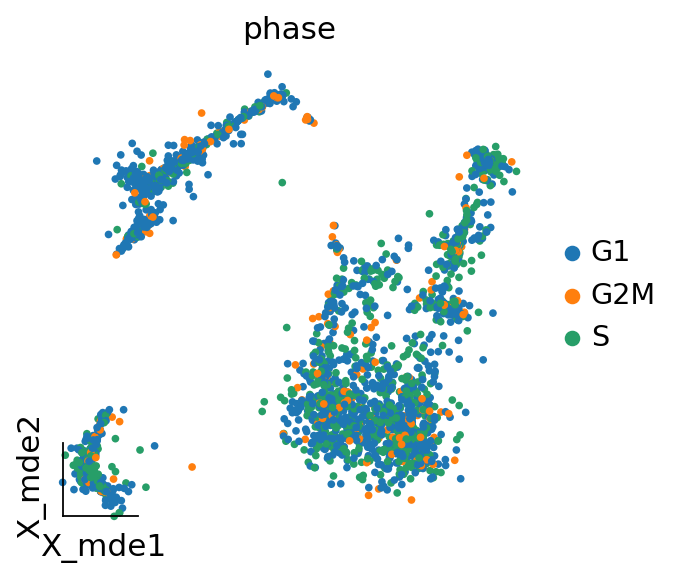

In [35]:
ov.pl.embedding(adata_raw,
                basis='X_mde',
                color='phase',
                frameon='small')

## 邻域图聚类

与Seurat和许多其他框架一样，我们推荐Traag等人(2018)的Leiden图聚类方法(基于优化模块化的社区检测)。注意，Leiden聚类直接对单元的邻域图进行聚类，我们已经在前一节中计算过了。

In [37]:
ov.pp.leiden(adata,resolution=1)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


我们重新设计了嵌入的可视化，通过添加参数`fraemon='small'`将其与`scanpy`的嵌入区分开来，这导致轴与颜色条进行缩放

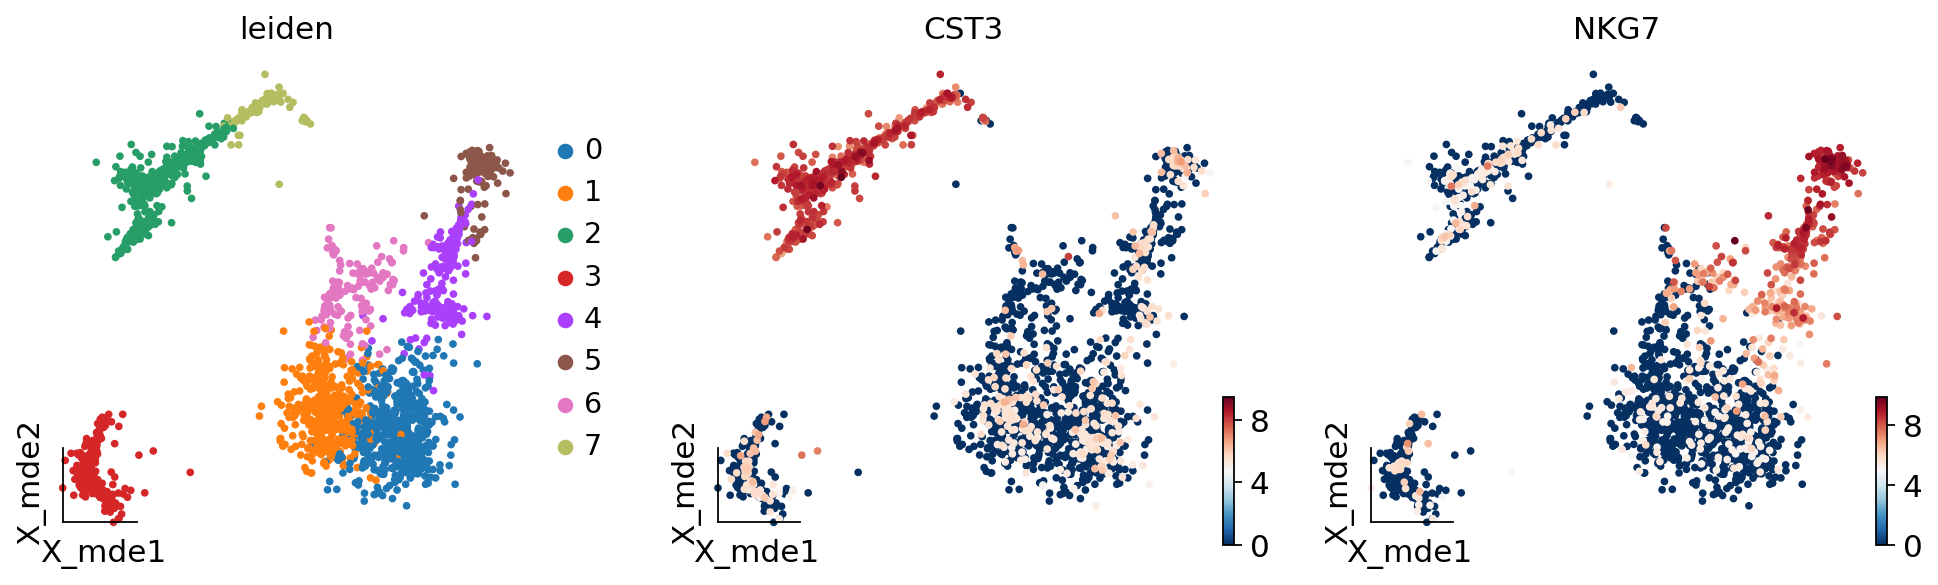

In [38]:
ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden', 'CST3', 'NKG7'],
                frameon='small')

我们还提供了一个边界可视化函数ov.utils.plot ConvexHull来可视化特定的集群。

Arguments:

- color: if None will use the color of clusters
- alpha: default is 0.2

leiden_colors


<AxesSubplot: title={'center': 'leiden'}, xlabel='X_mde1', ylabel='X_mde2'>

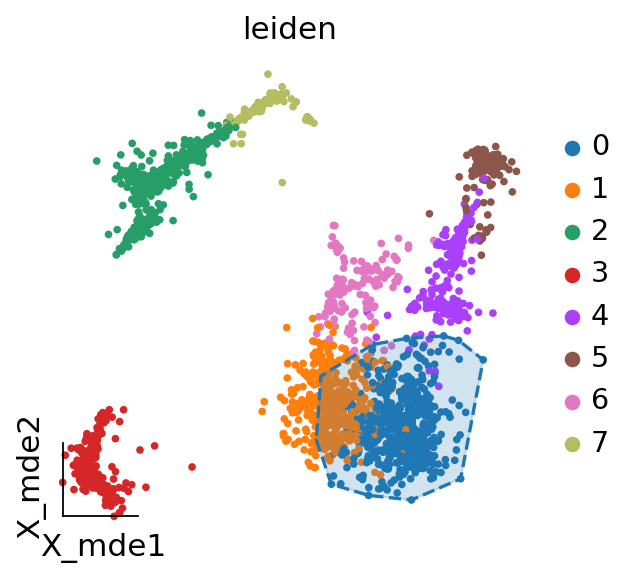

In [39]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots( figsize = (4,4))

ov.pl.embedding(adata,
                basis='X_mde',
                color=['leiden'],
                frameon='small',
                show=False,
                ax=ax)

ov.pl.ConvexHull(adata,
                basis='X_mde',
                cluster_key='leiden',
                hull_cluster='0',
                ax=ax)


如果您有太多的标签，例如太多的单元格类型，并且您担心单元格重叠，那么可以考虑尝试`ov.utils.gen_mpl_labels`函数，它可以改善文本重叠。此外，我们使用了`patheffects`

- adjust_kwargs: it could be found in package adjusttext
- text_kwargs: it could be found in class plt.texts

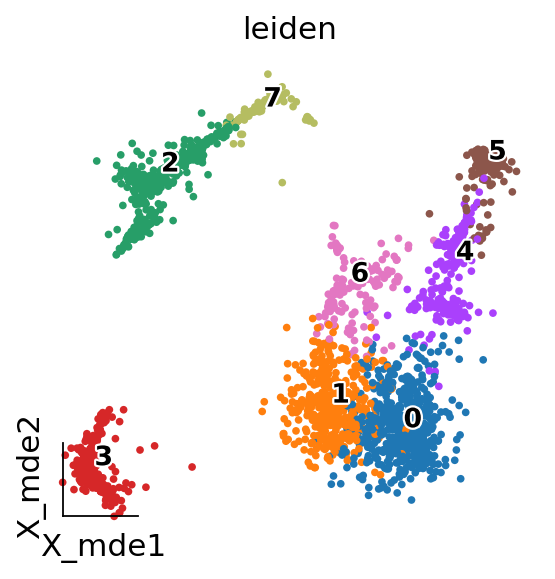

In [40]:
from matplotlib import patheffects
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,4))

ov.pl.embedding(adata,
                  basis='X_mde',
                  color=['leiden'],
                   show=False, legend_loc=None, add_outline=False, 
                   frameon='small',legend_fontoutline=2,ax=ax
                 )

ov.utils.gen_mpl_labels(
    adata,
    'leiden',
    exclude=("None",),  
    basis='X_mde',
    ax=ax,
    adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
    text_kwargs=dict(fontsize= 12 ,weight='bold',
                     path_effects=[patheffects.withStroke(linewidth=2, foreground='w')] ),
)

In [41]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

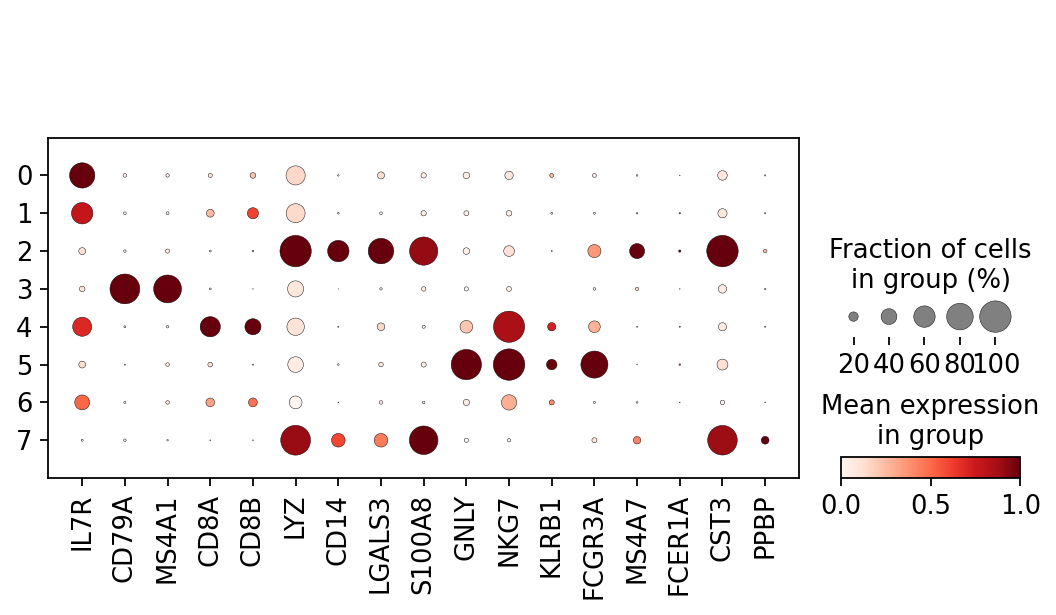

In [42]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden',
             standard_scale='var');

## Finding marker genes
让我们计算每个集群中差异很大的基因的排序。为此，默认情况下，如果之前已初始化，则使用AnnData的.raw属性。最简单和最快的方法是t检验。

Storing dendrogram info using `.uns['dendrogram_leiden']`
ranking genes
    finished: added to `.uns['leiden_ttest']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


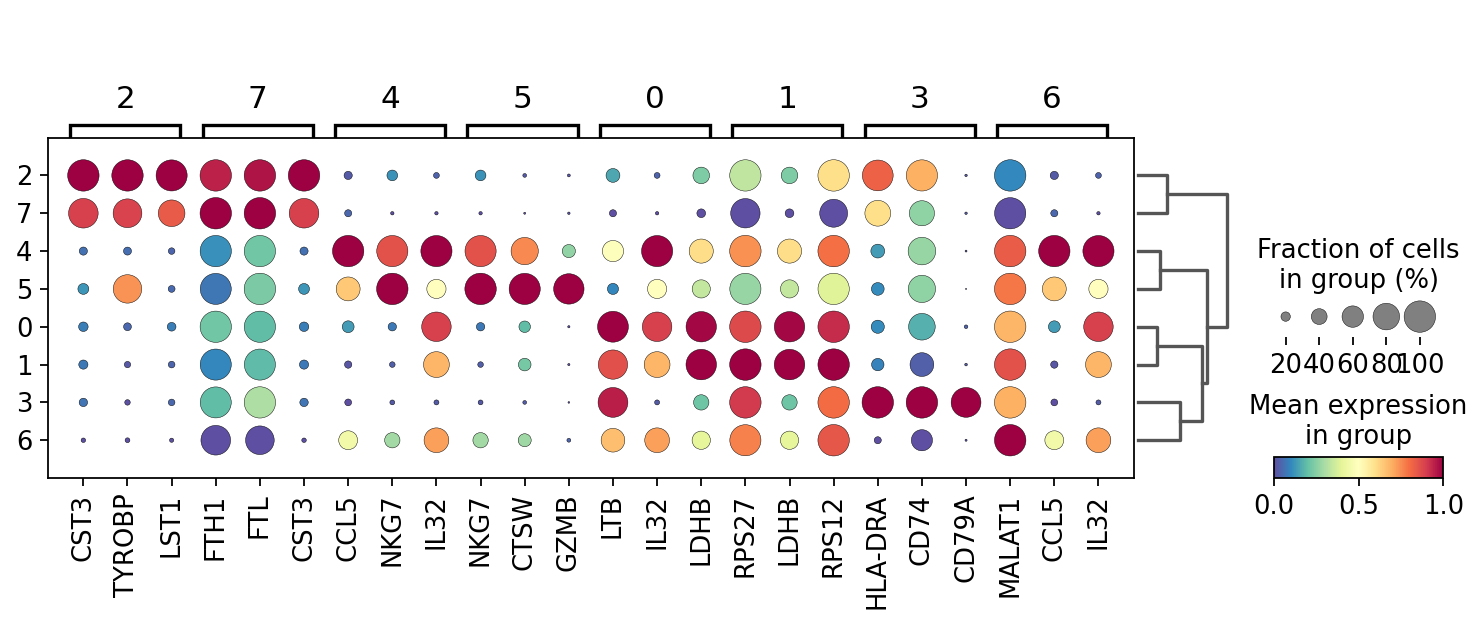

In [43]:
sc.tl.dendrogram(adata,'leiden',use_rep='scaled|original|X_pca')
sc.tl.rank_genes_groups(adata, 'leiden', use_rep='scaled|original|X_pca',
                        method='t-test',use_raw=False,key_added='leiden_ttest')
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_ttest',
                                standard_scale='var',n_genes=3)

Cosg也被认为是寻找标记基因的更好算法。这里，omicverse提供了成本的计算

Paper: [Accurate and fast cell marker gene identification with COSG](https://academic.oup.com/bib/advance-article-abstract/doi/10.1093/bib/bbab579/6511197?redirectedFrom=fulltext)

Code: https://github.com/genecell/COSG

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
**finished identifying marker genes by COSG**


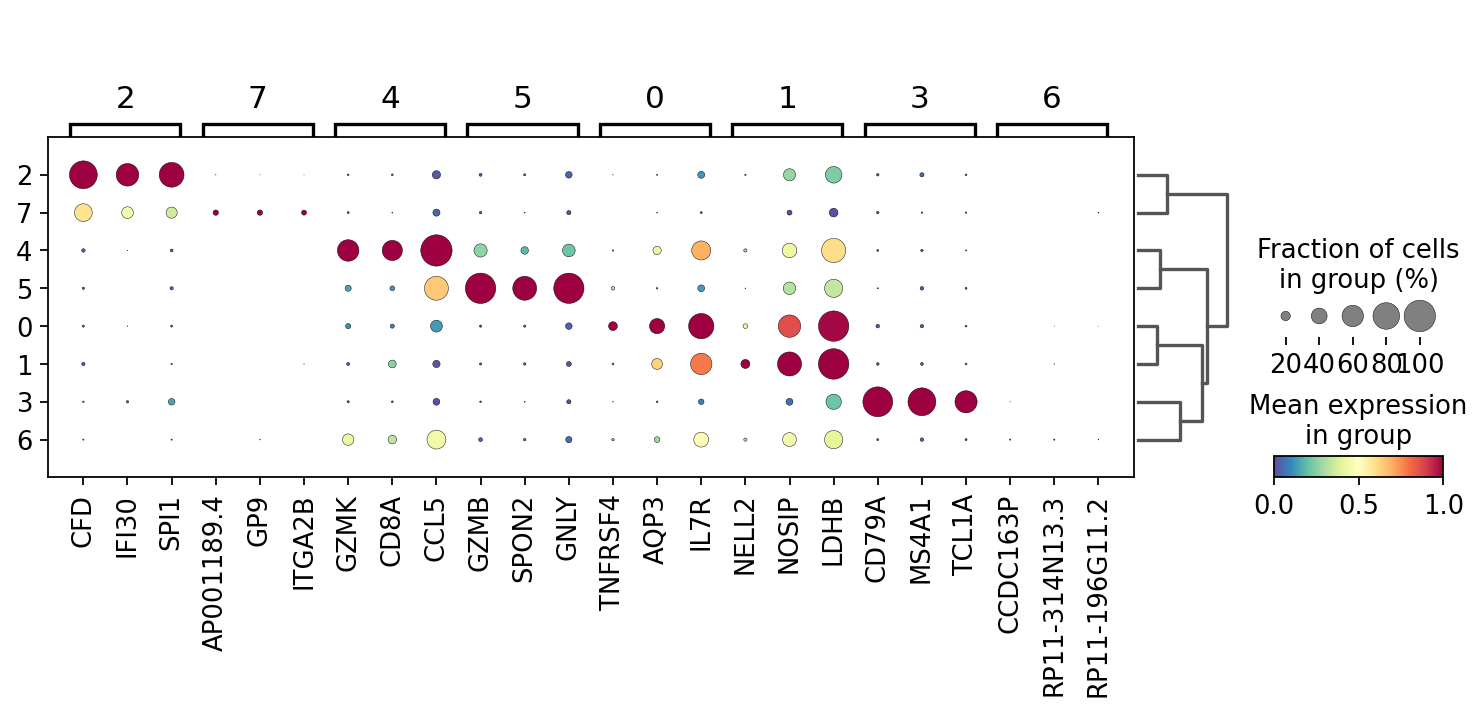

In [44]:
sc.tl.rank_genes_groups(adata, groupby='leiden', 
                        method='t-test',use_rep='scaled|original|X_pca',)
ov.single.cosg(adata, key_added='leiden_cosg', groupby='leiden')
sc.pl.rank_genes_groups_dotplot(adata,groupby='leiden',
                                cmap='Spectral_r',key='leiden_cosg',
                                standard_scale='var',n_genes=3)

## 其他绘图
接下来，让我们尝试另一个图表，我们称之为堆叠火山图。我们需要准备两个字典，一个是`data_dict`，一个是`color_dict`，它们都有相同的键要求。

用于`data_dict`。我们要求每个键中的内容是一个包含['names'，'logfoldchanges'，'pvals adj']的DataFrame，其中names代表基因名称，logfoldchanges代表差异表达多样性，pvals adj代表显著性p值

In [45]:
data_dict={}
for i in adata.obs['leiden'].cat.categories:
    data_dict[i]=sc.get.rank_genes_groups_df(adata, group=i, key='leiden_ttest',
                                            pval_cutoff=None,log2fc_min=None)

In [46]:
data_dict

{'0':          names     scores  logfoldchanges          pvals      pvals_adj
 0          LTB  30.052748        4.091112  7.076921e-167  1.415384e-163
 1         IL32  28.945974        4.642315  6.550286e-148  4.366857e-145
 2         LDHB  28.476921        3.823576  5.729472e-150  5.729472e-147
 3         CD3D  27.854069        4.423620  5.210961e-138  2.605480e-135
 4         IL7R  21.295935        4.207978   2.493022e-82   5.540048e-80
 ...        ...        ...             ...            ...            ...
 1995       CFD -20.108217       -4.602440   1.918471e-83   4.796179e-81
 1996    LGALS2 -20.297594       -4.789694   6.229173e-85   1.779764e-82
 1997  HLA-DRB1 -20.438972       -4.113003   8.357300e-82   1.671460e-79
 1998    FCER1G -21.595228       -4.333692   5.416741e-93   1.805580e-90
 1999  HLA-DRB5 -21.886024       -4.340186   2.722033e-95   1.088813e-92
 
 [2000 rows x 5 columns],
 '1':          names     scores  logfoldchanges          pvals      pvals_adj
 0        RPS

In [47]:
data_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7'])

In [48]:
data_dict[i].head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,FTH1,31.194271,2.883552,9.295679e-73,1.690123e-70
1,FTL,30.632479,3.278210,6.734846e-70,9.621208e-68
2,CST3,22.343149,6.886276,1.246625e-48,8.904462e-47
3,S100A8,20.467144,8.371758,3.558869e-42,1.977149e-40
4,S100A9,19.471075,7.732578,1.330719e-40,6.336756e-39


对于`color_dict`，我们要求将当前键显示的颜色存储在每个键中。

In [49]:
type_color_dict=dict(zip(adata.obs['leiden'].cat.categories,
                         adata.uns['leiden_colors']))
type_color_dict

{'0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#279e68',
 '3': '#d62728',
 '4': '#aa40fc',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#b5bd61'}

这里有许多参数可供我们自定义设置。请注意，当使用omicverse版本小于1.4.13绘制堆叠vol时，存在垂直坐标恒定在[-15,15]的错误，因此我们在本教程中添加了一些代码以实现可视化。

- data_dict: dict, in each key, there is a dataframe with columns of ['logfoldchanges','pvals_adj','names']
- color_dict: dict, in each key, there is a color for each omic
- pval_threshold: float, pvalue threshold for significant genes
- log2fc_threshold: float, log2fc threshold for significant genes
- figsize: tuple, figure size
- sig_color: str, color for significant genes
- normal_color: str, color for non-significant genes
- plot_genes_num: int, number of genes to plot
- plot_genes_fontsize: int, fontsize for gene names
- plot_genes_weight: str, weight for gene names

0 2
2 4
4 6
6 8
8 10
10 12
12 14
14 16


Text(0.5, 0.98, 'Stacking_vol')

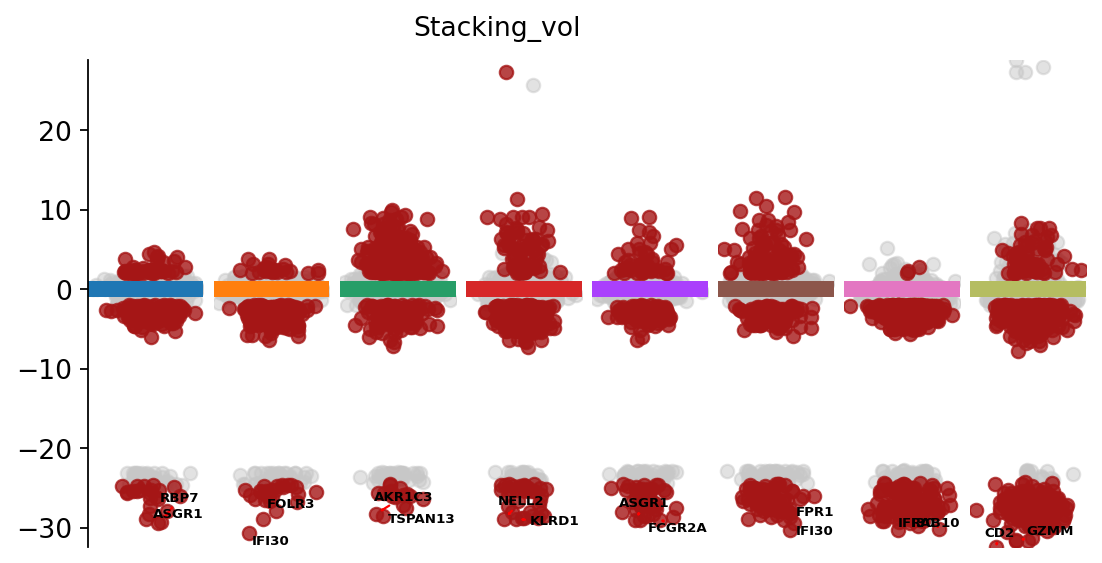

In [50]:
fig,axes=ov.utils.stacking_vol(data_dict,type_color_dict,
            pval_threshold=0.01,
            log2fc_threshold=2,
            figsize=(8,4),
            sig_color='#a51616',
            normal_color='#c7c7c7',
            plot_genes_num=2,
            plot_genes_fontsize=6,
            plot_genes_weight='bold',
            )

#The following code will be removed in future
y_min,y_max=0,0
for i in data_dict.keys():
    y_min=min(y_min,data_dict[i]['logfoldchanges'].min())
    y_max=max(y_max,data_dict[i]['logfoldchanges'].max())
for i in adata.obs['leiden'].cat.categories:
    axes[i].set_ylim(y_min,y_max)
plt.suptitle('Stacking_vol',fontsize=12)   